In [1]:
try:
  from transformer_lens import HookedTransformer
except:
  !pip install transformer_lens
  from transformer_lens import HookedTransformer

import tqdm.auto as tqdm
import numpy as np
import torch as t
import matplotlib.pyplot as plt

In [2]:
def make_restoration_hook(clean_cache, token):
    # activation_name: mlp, attention

    def corrupt_with_restoration_hook_func(corrupted_activation_value,
                                           hook):
        corrupted_activation_value[:, token] = clean_cache[hook.name][:, token]
        return corrupted_activation_value
    return corrupt_with_restoration_hook_func

In [7]:
def causal_tracing(model: HookedTransformer,
                   clean_cache,
                   corrupted_tokens: t.Tensor,
                   layer_to_restore,
                   token_to_restore,
                   type_to_patch):  # type of layer to patch ("resid", "mlp" or "attention")

    ### Corrupted-with-restoration run
    # i.e. run w/ corrupted input while restoring/replacing
    # the activations for 1 token + layer combination with the clean activations
    if type_to_patch == "resid":
        state_to_patch = [f"blocks.{layer_to_restore}.hook_resid_pre"]
    elif type_to_patch == "mlp":
        state_to_patch = [f"blocks.{layer}.hook_mlp_out" for layer in range(max(0, layer_to_restore - 5), min(model.cfg.n_layers, layer_to_restore + 5))]
    elif type_to_patch == "attention":
        # this is the linear combination of value vectors
        # gets multiplied by the W_O to produce the output of the attention layer
        state_to_patch = [f"blocks.{layer}.attn.hook_z" for layer in range(max(0, layer_to_restore - 5), min(model.cfg.n_layers, layer_to_restore + 5))]

    hook = make_restoration_hook(clean_cache, token_to_restore)
    corrupted_with_restoration_logits = model.run_with_hooks(corrupted_tokens,
                                                             fwd_hooks=[(state, hook) for state in state_to_patch])


    return corrupted_with_restoration_logits

In [4]:
def prob_attribute(corrupt_with_restoration_logits,
                    obj_token_idx  # object token id in dictionary
                    ):
    return corrupt_with_restoration_logits.softmax(-1)[0, -1, obj_token_idx]

def indirect_effect(corrupt_logits,
                    corrupt_with_restoration_logits,
                    obj_token_idx  # object token id in dictionary
                    ):
    # = prob of obj (object) in corrupt_restoration - prob of obj under corrupt runs
    # TODO: what range is reasonable for IE?
    print("Indirect effect", corrupt_logits.shape, obj_token_idx, )
    return corrupt_with_restoration_logits.softmax(-1)[0, -1, obj_token_idx] - corrupt_logits.softmax(-1)[0, -1, obj_token_idx]


In [5]:
m_name = "gpt2-large"
#m_name = "gpt2-xl"
gpt: HookedTransformer = HookedTransformer.from_pretrained(model_name=m_name, device="cpu")

example_1 = {
            "known_id": 2,
            "subject": "Audible.com",
            "attribute": "Amazon",
            "template": "{} is owned by",
            "prediction": " Amazon.com, Inc. or its affiliates.",
            "prompt": "Audible.com is owned by",
            "corrupt_prompt": "Spotify is owned by",
            "relation_id": "P127"
        }
example_2 = {"subject": "Mary",
              "prompt": "Mary had a little lamb, something",
              "corrupt_prompt": "Nina had a little lamb, something"
        }

example_3 = {"subject": "Rome",
              "prompt": "Rome is the capital of",
              "corrupt_prompt": "Paris is the capital of"
        }
example_rome = {"subject": "The Space Needle",
                "prompt": "The Space Needle is in downtown",
                "corrupt_prompt": "The Square Beetle is in downtown",
                "attribute": "Seattle"}

example = example_rome

clean_tokens = gpt.to_tokens(example["prompt"])
corrupted_tokens = gpt.to_tokens(example["corrupt_prompt"])

num_tokens = corrupted_tokens.shape[-1]
subject_dim = gpt.to_tokens(example["subject"]).shape[-1]

clean_logits, clean_cache = gpt.run_with_cache(clean_tokens)
corrupted_logits, _ = gpt.run_with_cache(corrupted_tokens)

resid_stream_out = t.zeros((num_tokens, gpt.cfg.n_layers))

obj_token_id =  gpt.to_single_token(example["attribute"])

prompt = gpt.to_str_tokens(example_rome["prompt"])[1:]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded pretrained model gpt2-large into HookedTransformer


In [8]:
layer_types = ["resid", "mlp", "attention"]
#layer_types = ["mlp"]

# dim 0: resid, mlp, attention
causal_tracing_out = t.zeros((len(layer_types), num_tokens, gpt.cfg.n_layers))

for i in tqdm.tqdm(range(len(layer_types))):
    for layer in tqdm.tqdm(range(gpt.cfg.n_layers)):
        for position in range(num_tokens):
            #print(f"Restoring layer {layer}, token {position+1}/{num_tokens}")
            corrupted_with_restoration_logits = causal_tracing(model=gpt,
                                                            clean_cache=clean_cache,
                                                            corrupted_tokens=corrupted_tokens,
                                                            layer_to_restore=layer,
                                                            token_to_restore=position,
                                                            type_to_patch=layer_types[i])

            causal_tracing_out[i, position, layer] = (prob_attribute(corrupt_with_restoration_logits=corrupted_with_restoration_logits,
                                                                     obj_token_idx=obj_token_id)).item()
            '''causal_tracing_out[i, position, layer] = (indirect_effect(corrupt_logits=corrupted_logits,
                                                corrupt_with_restoration_logits=corrupted_with_restoration_logits,
                                                obj_token_idx=obj_token_id)).item()'''


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [9]:
def plot_fig1(indirect_effect, prompt):
    ax = plt.imshow(indirect_effect, cmap="RdBu")
    cbar = plt.colorbar(ax)
    cbar.ax.set_ylabel("p(attribute)")
    plt.yticks(range(len(prompt)), prompt)


# Causal impact of restoring states after input corruption


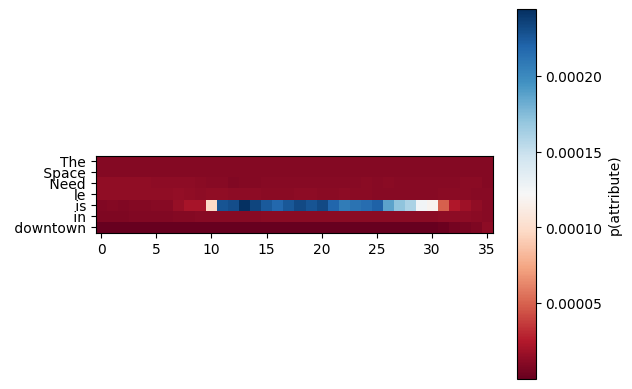

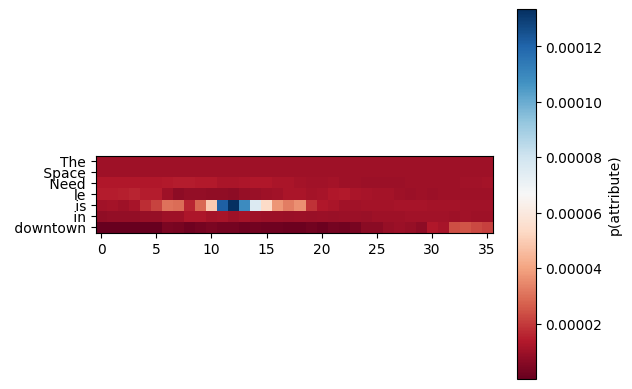

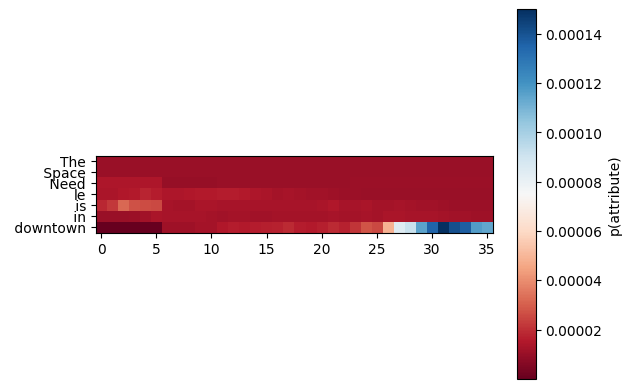

In [10]:
for i in range(len(layer_types)):
    # TODO: the color bar contains the probability of the "attribute" token
    plot_fig1(causal_tracing_out[i].numpy(), prompt)
    plt.show()